In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from PIL import Image
import os
import spacy
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.models import inception_v3, Inception_V3_Weights

import os
os.system("python -m spacy download en_core_web_sm")

2025-05-13 13:03:01.012859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747134181.035892 1483381 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747134181.042788 1483381 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747134181.063983 1483381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747134181.064009 1483381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747134181.064011 1483381 computation_placer.cc:177] computation placer alr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.9 MB/s eta 0:00:0000:01



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


0

In [2]:
import matplotlib.pyplot as plt

def visualize_caption(model, image_path, vocabulary, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    caption_tokens = model.caption_image(image_tensor, vocabulary)
    caption = ' '.join(caption_tokens)

    plt.imshow(image)
    plt.title(caption)
    plt.axis("off")
    plt.show()


In [13]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(model, data_loader, vocab, device, num_examples=100):
    model.eval()
    total_score = 0
    smooth = SmoothingFunction().method4
    count = 0

    for idx, (images, captions) in enumerate(data_loader):
        if count >= num_examples:
            break
        images = images.to(device)

        for i in range(images.shape[0]):
            output = model.caption_image(images[i].unsqueeze(0), vocab)
            reference = [vocab.tokenizer_eng(" ".join([vocab.itos[token.item()] for token in captions[:, i] if token.item() not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]))]
            score = sentence_bleu(reference, output, smoothing_function=smooth)
            total_score += score
            count += 1
            if count >= num_examples:
                break

    return total_score / count


In [3]:
IMAGE_DIR = 'Flickr8k/Flickr8k/Images/'
CAPTION_FILE = 'Flickr8k/Flickr8k/captions.txt'
spacy_eng = spacy.load("en_core_web_sm")

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):

        # Both of these will be dict where the information is stored

        #Index to string where 0 = is the PAD (padding)
        # 1 = SOS (start of sentence) 
        # 2 = EOS (end of sentence)
        # 3 = UNK (unknown) if word is not repeated over freq_threshold it will be mapped to UNK
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        # Reverse So this will be String to index
       
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        # "Hi MR how are you" -> ["hi","mr","how","are","you"]
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4


        # This part of the code check if the words in the sentence_list occure more
        # than the freq_threshold we will not include them in the vocab
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        # Take in a text and turn them into numerical value
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        # Here we create the a string to index where SOS means start of sentence and EOS is the End of sentences

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)



In [6]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets



In [7]:
def get_loader(
        root_folder,
        annotation_file,
        transform,
        batch_size=32,
        num_workers=2,
        shuffle=True,
        pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


transform = transforms.Compose([
    # make the shorter side 256px, keep aspect ratio
    transforms.Resize(256),

    # then take a random 224×224 crop
    transforms.RandomCrop(224),

    transforms.ToTensor(),

    # use ImageNet’s mean/std for ResNet
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    ),
])

#loader, dataset = get_loader(IMAGE_DIR, CAPTION_FILE, transform=transform)

#for idx, (images, captions) in enumerate(loader):
#    print(images.shape)     # (batch_size, 3, 299, 299)
#    print(captions.shape)   # (seq_len, batch_size)
#    break

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN

        # load pretrained ResNet-50
        weights = ResNet50_Weights.DEFAULT
        self.resnet = resnet50(weights=weights)

        # replace the final fully-connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, embed_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

        # freeze all except the new FC (will override in forward too)
        for name, param in self.resnet.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_CNN

    def forward(self, images):
        """
        images: Tensor of shape (B, 3, H, W)
        returns: Tensor of shape (B, embed_size)
        """
        features = self.resnet(images)    # single output vector per image
        x = self.relu(features)
        x = self.dropout(x)
        return x

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [10]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)

                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [27]:
def train():
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std= [0.229, 0.224, 0.225]
        ),
    ])

    train_loader, dataset = get_loader(
        root_folder=IMAGE_DIR,
        annotation_file=CAPTION_FILE,
        transform=transform,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 10

    writer = SummaryWriter("runs/flickr_ResNet50")
    step = 0

    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    import time
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}] starting...")


        for idx, (imgs, captions) in enumerate(train_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] | Step [{idx}/{len(train_loader)}] | Loss: {loss.item():.4f}")

        # Compute BLEU score once per epoch
        model.eval()
        bleu = compute_bleu(model, train_loader, dataset.vocab, device, num_examples=100)
        writer.add_scalar("BLEU Score", bleu, global_step=step)
        print(f"Epoch [{epoch+1}] BLEU score: {bleu:.4f}")
        model.train()

        epoch_end = time.time()
        print(f"Epoch [{epoch+1}] completed in {(epoch_end - epoch_start)/60:.2f} min")

    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.2f} minutes.")

    visualize_caption(model, "Flickr8k/Flickr8k/Images/3637013_c675de7705.jpg", dataset.vocab, transform, device)
    return model, dataset, device


Epoch [1/10] starting...
Epoch [1/10] | Step [0/1265] | Loss: 8.0048
Epoch [1/10] | Step [100/1265] | Loss: 4.4394
Epoch [1/10] | Step [200/1265] | Loss: 4.2078
Epoch [1/10] | Step [300/1265] | Loss: 3.8497
Epoch [1/10] | Step [400/1265] | Loss: 3.6817
Epoch [1/10] | Step [500/1265] | Loss: 3.8645
Epoch [1/10] | Step [600/1265] | Loss: 3.8181
Epoch [1/10] | Step [700/1265] | Loss: 3.3612
Epoch [1/10] | Step [800/1265] | Loss: 3.3703
Epoch [1/10] | Step [900/1265] | Loss: 3.2965
Epoch [1/10] | Step [1000/1265] | Loss: 3.2722
Epoch [1/10] | Step [1100/1265] | Loss: 3.2059
Epoch [1/10] | Step [1200/1265] | Loss: 3.4859
Epoch [1] BLEU score: 0.0300
Epoch [1] completed in 2.31 min
Epoch [2/10] starting...
Epoch [2/10] | Step [0/1265] | Loss: 3.2916
Epoch [2/10] | Step [100/1265] | Loss: 3.4462
Epoch [2/10] | Step [200/1265] | Loss: 3.1891
Epoch [2/10] | Step [300/1265] | Loss: 3.0848
Epoch [2/10] | Step [400/1265] | Loss: 3.0810
Epoch [2/10] | Step [500/1265] | Loss: 3.2348
Epoch [2/10] | S

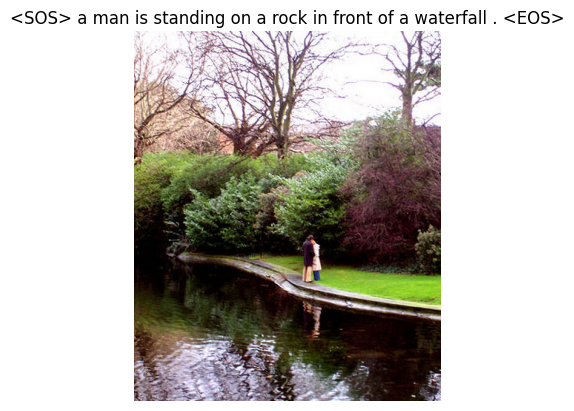

In [28]:
model, dataset, device = train()

Processing: Flickr8k/Flickr8k/Images/2504277798_936a09c74d.jpg


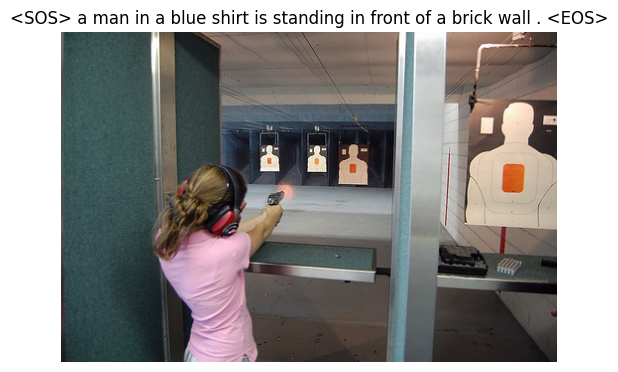

Processing: Flickr8k/Flickr8k/Images/1650280501_29810b46e5.jpg


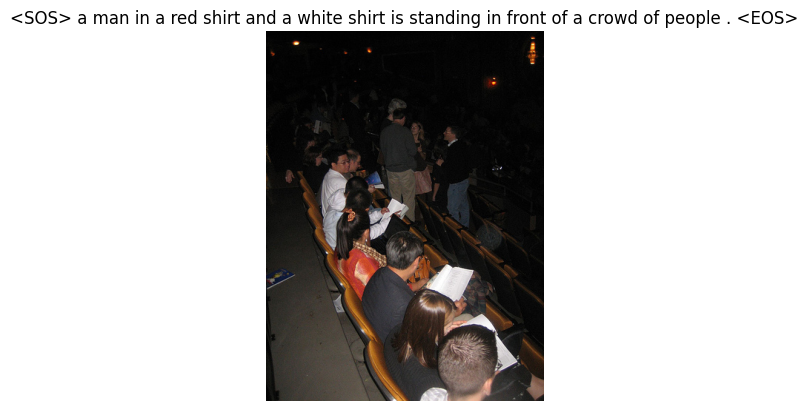

Processing: Flickr8k/Flickr8k/Images/3501386648_e11e3f3152.jpg


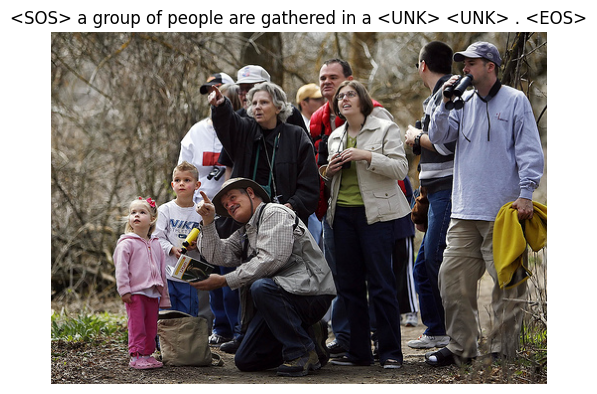

Processing: Flickr8k/Flickr8k/Images/104136873_5b5d41be75.jpg


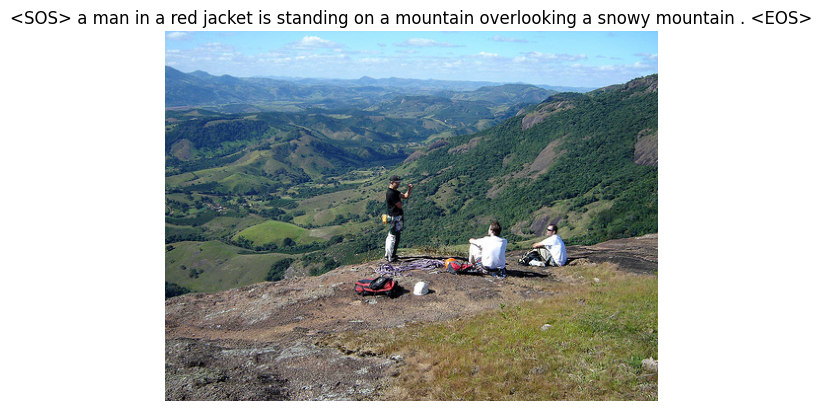

Processing: Flickr8k/Flickr8k/Images/3528902357_be2357a906.jpg


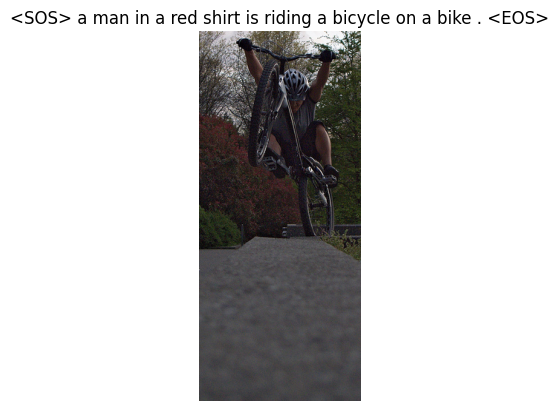

Processing: Flickr8k/Flickr8k/Images/3155501473_510f9c9f6b.jpg


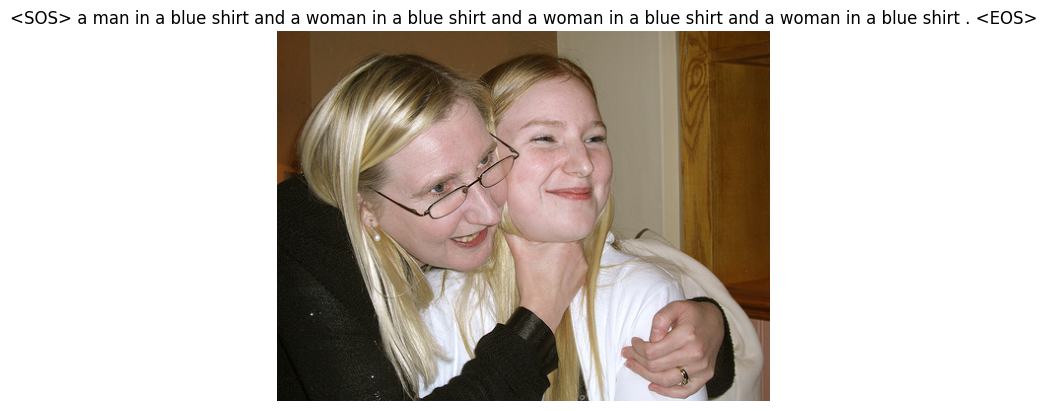

Processing: Flickr8k/Flickr8k/Images/3429581486_4556471d1a.jpg


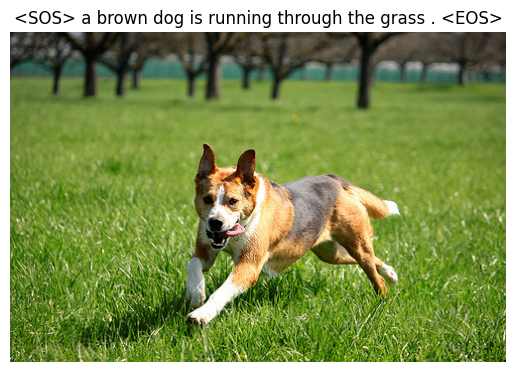

Processing: Flickr8k/Flickr8k/Images/2420730259_86e7f8a815.jpg


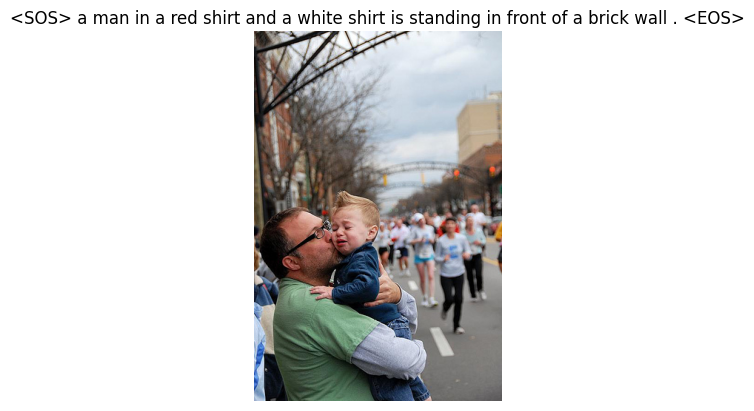

Processing: Flickr8k/Flickr8k/Images/468930779_8008d90e10.jpg


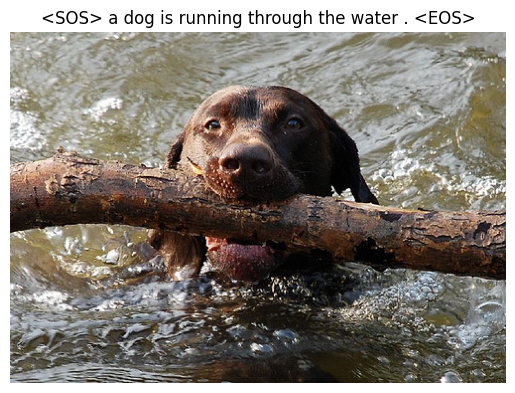

Processing: Flickr8k/Flickr8k/Images/3425853460_bfcd0b41f6.jpg


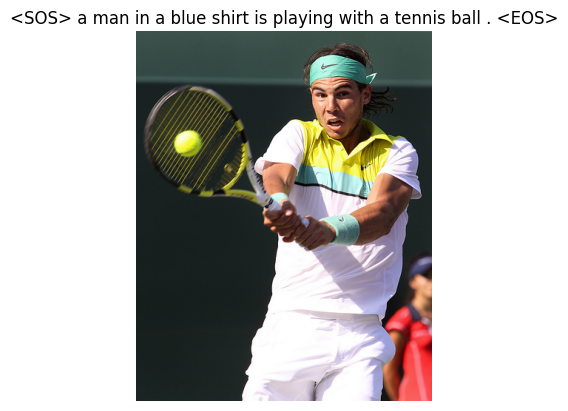

Processing: Flickr8k/Flickr8k/Images/753285176_f21a2b984d.jpg


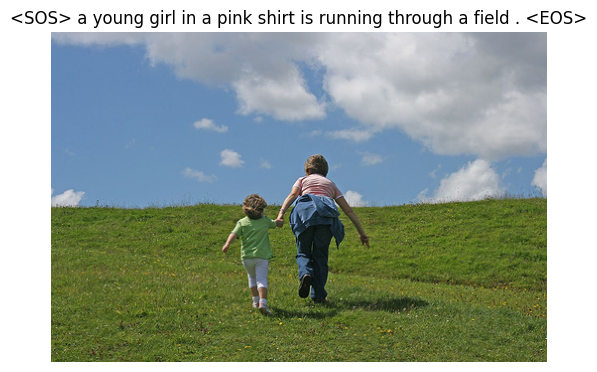

Processing: Flickr8k/Flickr8k/Images/3706653103_e777a825e4.jpg


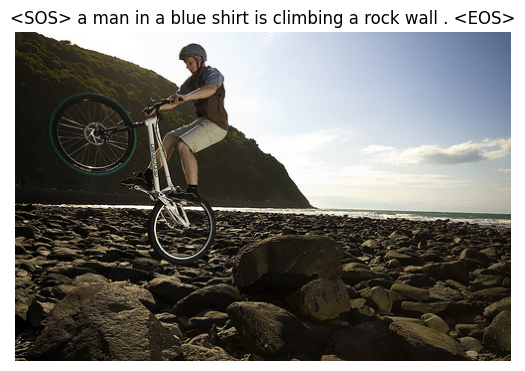

Processing: Flickr8k/Flickr8k/Images/3713133789_f05e8daffd.jpg


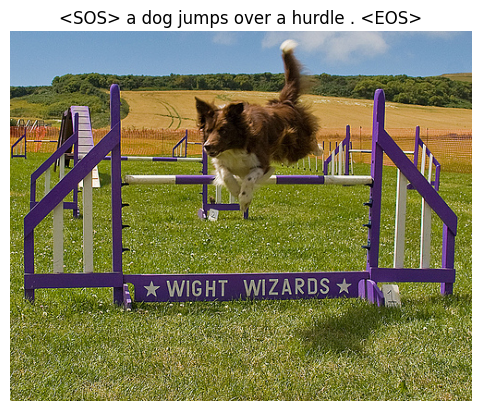

Processing: Flickr8k/Flickr8k/Images/475317104_1cdc1653b4.jpg


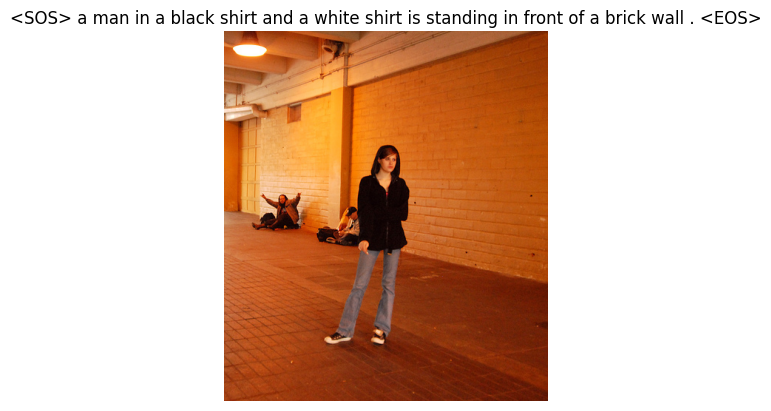

Processing: Flickr8k/Flickr8k/Images/2339516180_12493e8ecf.jpg


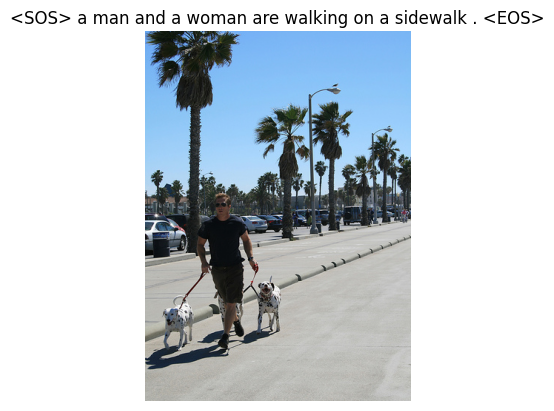

Processing: Flickr8k/Flickr8k/Images/2868668723_0741222b23.jpg


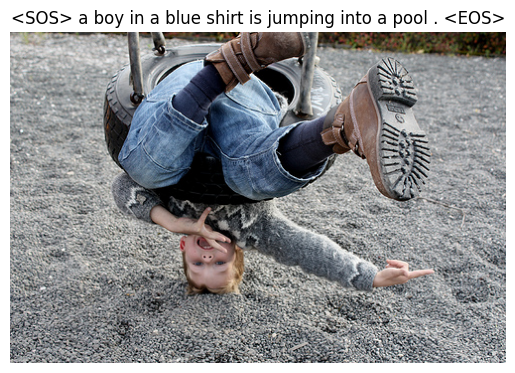

Processing: Flickr8k/Flickr8k/Images/3334537556_a2cf4e9b9a.jpg


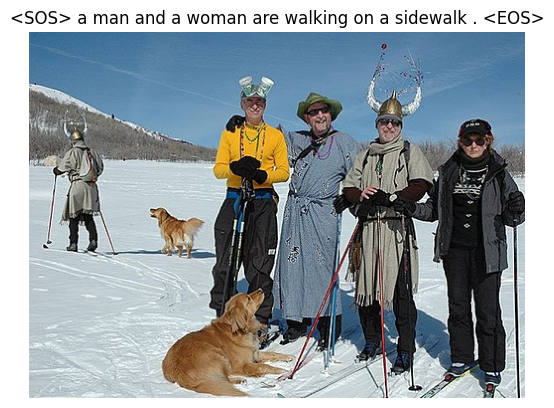

Processing: Flickr8k/Flickr8k/Images/2429272699_8a9699775e.jpg


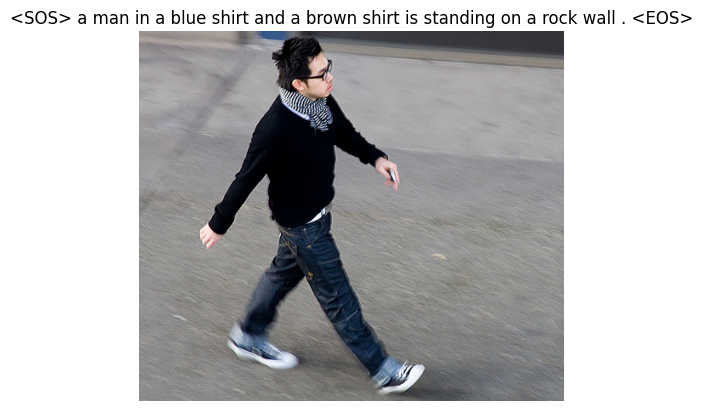

Processing: Flickr8k/Flickr8k/Images/3655155990_b0e201dd3c.jpg


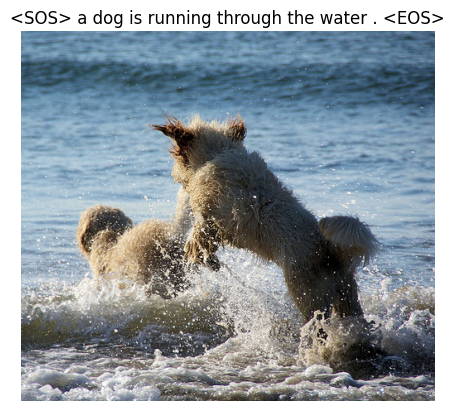

Processing: Flickr8k/Flickr8k/Images/3217893350_57be430d06.jpg


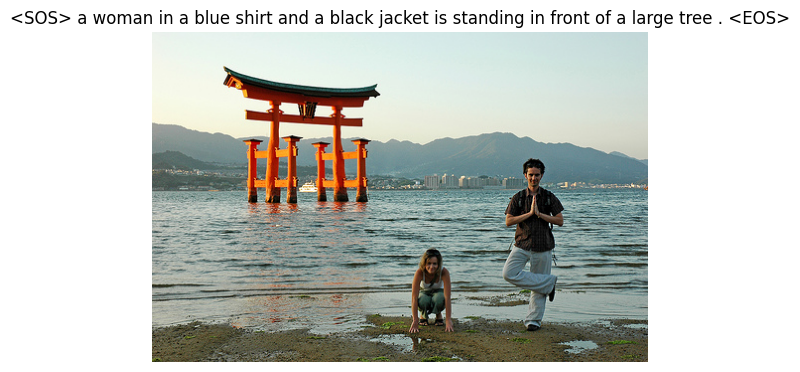

In [33]:
transform = transforms.Compose([
            # make the shorter side 256px, keep aspect ratio
            transforms.Resize(256),
        
            # then take a random 224×224 crop
            transforms.RandomCrop(224),
        
            transforms.ToTensor(),
        
            # use ImageNet’s mean/std for ResNet
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std= [0.229, 0.224, 0.225]
            ),
        ])

import random

# Folder containing the images
image_folder = "Flickr8k/Flickr8k/Images"

# Get all image files in the folder
all_images = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)
              if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Make sure there are at least 10 images
if len(all_images) < 20:
    raise ValueError("Not enough images in the folder to select 10 unique ones.")

# Select 10 unique random images
selected_images = random.sample(all_images, 20)

# Process each selected image
for image_path in selected_images:
    print(f"Processing: {image_path}")
    visualize_caption(model, image_path, dataset.vocab, transform, device)